In [1]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from core.analysis import *
from core import semcor_bert_pipeline
from core.metrics import *

<Figure size 432x288 with 0 Axes>

## Binary Logistic Regression

For the shared words, we find that homonymous and polysemous senses are able to be distinguished

In [2]:
shared_metrics = {}
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']
fmt_sense_12 = lambda w: [w + '.01', w + '.02']
shared_senses = [fmt_sense_12(w) for w in shared_words]
shared_senses[-1] = ['degree.n.01', 'academic_degree.n.01']
shared_senses[1] = ['airplane.n.01', 'plane.n.02']
for w_s in zip(shared_words, shared_senses):
    model_data = binary_logistic(w_s[0], w_s[1])
    weight_values, weight_indices = nonzero_weights(model_data['model'])
    f_scores, accuracies, wrong_indices = k_fold_cv(model_data['data'], model_data['transformed_labels'], k = )
    shared_metrics[w_s[0]] = {'senses': w_s[1], 'data': model_data, 'weights': weight_values,
                    'weight_indices': weight_indices, 'f1_kfold': f_scores, 'acc_kfold': accuracies,
                             'incorrect_indices': wrong_indices}
    

/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [3]:
shared_stats = []
incorrect = []
for k in shared_metrics:
    word_results = shared_metrics[k]
    weights = word_results['weights']
    incorrect.append(misclassified_sentences(word_results['data'], word_results['incorrect_indices']))
    shared_stats.append({'word_type': k, 'avg_f1': np.mean(word_results['f1_kfold']), 'avg_acc': np.mean(word_results['acc_kfold']),
    'pct_nonzero_weights': len(weights) / 768, 'max_wt': max(weights), 'min_wt': min(weights), 'mean_nonzero_wt': np.mean(weights), 'sd_nonzero_wt': np.std(weights)})
pd.DataFrame(shared_stats)

,word_type,avg_f1,avg_acc,pct_nonzero_weights,max_wt,min_wt,mean_nonzero_wt,sd_nonzero_wt
0,foot.n,1.000000,1.000000,0.031250,0.221638,-0.229722,0.028953,0.132456
1,plane.n,0.933333,0.980000,0.015625,0.491381,-0.265000,0.054483,0.223284
2,model.n,0.518095,0.885455,0.037760,0.274155,-0.291541,0.020775,0.136917
3,table.n,0.992000,0.993548,0.033854,0.475794,-0.253788,0.013552,0.151044
4,degree.n,1.000000,1.000000,0.018229,0.456742,-0.227727,0.001208,0.166292


Misclassified senses (Only binary classification, 3/16 senses for math plane were misclassified)

In [4]:
pd.set_option('display.max_colwidth', 500)
pd.concat(incorrect)

,true_label,sentences
0,plane.n.02,The plane of the action in the scene is not parallel with the plane of the film in the camera or on the screen .
0,model.n.01,His first model arrived at dusk .
1,model.n.01,"We devote a chapter to the binomial distribution not only because it is a mathematical model for an enormous variety of real life phenomena , but also because it has important properties that recur in many other probability models ."
2,model.n.01,His first model arrived at dusk .
3,model.n.01,His first model arrived at dusk .
4,model.n.01,The model quite plainly thought Michelangelo crazy ; only the instructions from his rabbi kept him from bolting .
5,model.n.01,"But at the end of the sitting , when Michelangelo showed him the quick , free drawings , with the mother roughed in , holding her son , the model grasped what Michelangelo was after , and promised to speak to his friends ."
0,table.n.01,The registration figures given in Table 2 must be interpreted with caution since the estimate for eligible electors were made without the benefit of a reliable census .


I thought this might be useful to see if weights at similar positions were used.

In [7]:
[(k, shared_metrics[k]['weight_indices']) for k in shared_words]

[('foot.n',
  array([ 13,  29,  40,  70,  89, 184, 191, 217, 231, 278, 287, 304, 308,
         332, 493, 518, 528, 532, 547, 637, 664, 693, 709, 730])),
 ('plane.n',
  array([105, 157, 254, 286, 308, 324, 411, 413, 448, 513, 539, 619])),
 ('model.n',
  array([ 18,  49,  68,  74,  79, 101, 114, 242, 254, 259, 282, 289, 340,
         364, 450, 473, 477, 509, 520, 523, 525, 527, 552, 574, 586, 597,
         618, 739, 749])),
 ('table.n',
  array([ 37,  67,  94, 136, 143, 188, 213, 228, 252, 286, 298, 317, 332,
         334, 363, 376, 393, 445, 481, 487, 552, 661, 666, 680, 705, 753])),
 ('degree.n',
  array([ 15,  22, 220, 262, 328, 350, 432, 523, 537, 541, 544, 620, 622,
         724]))]

## All Classes

In [2]:
db = access_db()

In [3]:
shared_model_data = {}
shared_stats = []
incorrect = []
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']
for w in shared_words:
    print(w) #Checking where the model doesn't converge
    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.n', "_n"))],
                               use_masc = False)
    shared_model_data[w] = model_results
    shared_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_acc': np.mean(model_results['acc'])})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

foot.n
plane.n


/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


model.n
table.n
degree.n
right.n


In [4]:
pd.DataFrame(shared_stats)

,word,avg_f1,avg_acc
0,foot.n,1.000000,1.000000
1,plane.n,0.877063,0.896429
2,model.n,0.944762,0.942857
3,table.n,0.916221,0.925735
4,degree.n,0.564776,0.580000
5,right.n,0.972721,0.963636


/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


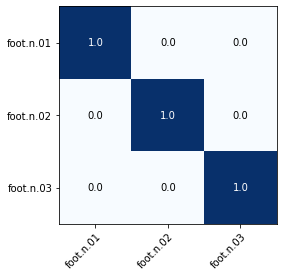

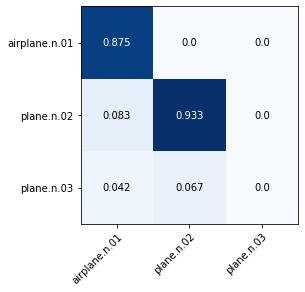

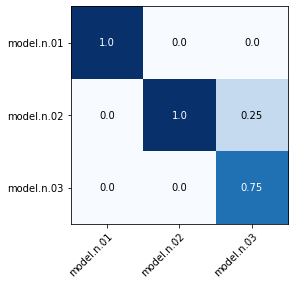

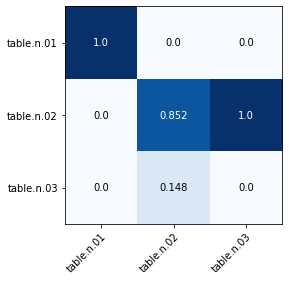

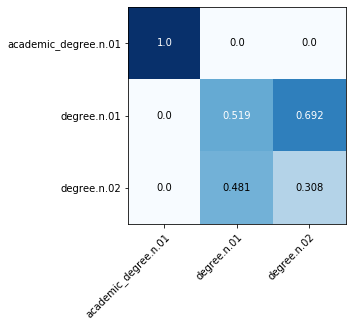

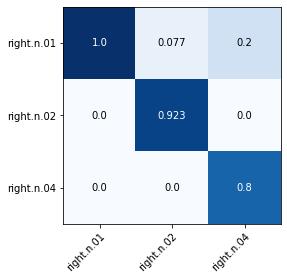

In [32]:
for w in shared_words:
    word_matrices = shared_model_data[w]['confusion_matrices']
    senses = [fb_to_local(s) for s in get_senses(db, w.replace('.n', "_n"))]
    plot_confusion_mtx(word_matrices, senses)

In [16]:
pd.set_option('display.max_colwidth', 500)

pd.concat(incorrect)

,true_label,sentences
0,foot.n.02,"Hans Schweizer had one that increased from 19 - 1 2 inches to 5 feet 3 inches in five years , and J . J . Quelch records a growth of from less than 4 feet to nearly 10 in about six years ."
0,plane.n.02,"If a is the major axis of an ellipsoid and b and c are the other two axes , the radius of curvature in the ab plane at the end of the axis is * * f , and the difference in pressure along the a and b axes is * * f ."
1,plane.n.02,"Also , planetary gravitational attraction increases the dust concentration near the plane of the ecliptic as the sun is approached ."
0,model.n.03,He worked for two hours a day with each model sent by the rabbi .
1,model.n.03,His first model arrived at dusk .
0,table.n.01,"Although the standard deviation values on which spread of the lines are based are relatively larger for those centers which begin to ossify early ( Table 1 ) , there are considerable differences in this value between centers having the closely timed Onsets ."
1,table.n.01,It was stated earlier that one purpose of this study was to extend the analysis of variability of Onset and Completion in each of the 21 growth centers somewhat beyond that provided by the data in Tables 1 and 2 .
2,table.n.01,"It may be assumed that differences in ratings due to selection of growth centers from specific regions of the body will be small , according to existing tables of onset age and completion age for centers throughout the body ."
0,academic_degree.n.01,Dr. Clark holds an earned Doctor of Education degree from the University of Oklahoma .
1,academic_degree.n.01,"He also received a Master of Science degree from Texas A+I College and a Bachelor of Science degree from Southwestern State College , Weatherford , Okla. ."


## Weight Analyses

If we look at cosine distance of centroids, will we achieve comparable results using only the embeddings at indices that had nonzero weights? Here, we apply the same analyses that we did comparing the experiment data to the centroids of the full BERT embeddings.

In [59]:
for w in shared_model_data.keys():
    results = shared_model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w)

NameError: name 'shared_model_data' is not defined

In [ ]:
semcor_bert_pipeline.load_data()

In [68]:
from sklearn.manifold import MDS

In [61]:
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']


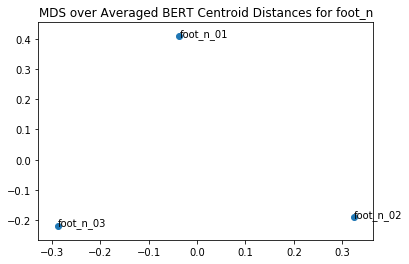

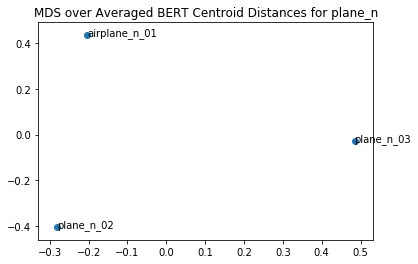

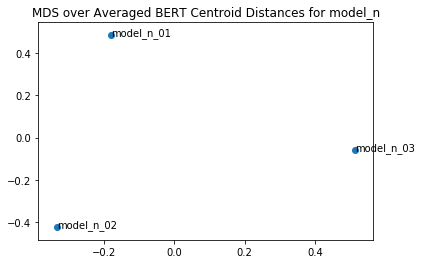

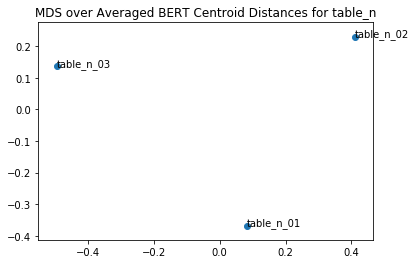

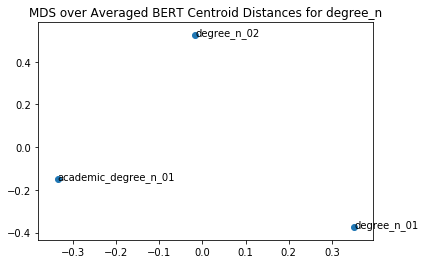

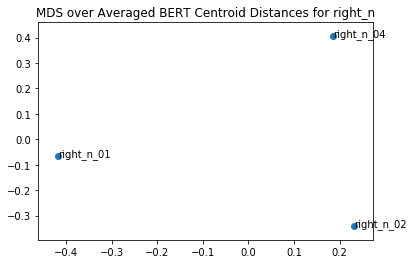

In [65]:
for w in shared_words:
    result_mtx, sense_names = cosine_sim_mtx(w.replace('.n', ''), 'n',sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.', "_"))],
                                            corpus = 'select_weights', use_masc = False, normalize = False)
    mds_model = MDS(n_components = 2, dissimilarity = 'precomputed')
    plot_mds(result_mtx, w.replace('.', '_'), mds_model, db, "BERT Centroid")

In [66]:
results, incl_users = get_results_elig_users(db, 'Self Consistency', 0.2)

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [67]:
shared_words = [w.replace('.', '_') for w in shared_words]
matrices = {w: {} for w in shared_words}

#print("Spearman Rank Correlations for Shared Words")
for w in shared_words:
    expt_means = mean_distance_mtx(results, w.replace('.', '_'), 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_means
    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))],
                                         corpus = 'select_weights', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs


In [69]:
all_human_avg = [matrices[w]['expt'] for w in shared_words]
all_bert_cs = [matrices[w]['bert'] for w in shared_words]
bert_human_shared = mtx_correlation(all_human_avg, all_bert_cs, method = 'pearson')
bert_human_shared

0.7167344020177626

For reference, using the full set of BERT embeddings, the correlation was 0.76